In [1]:
import sys
sys.path.insert(0, '../')

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
fsize = 18
params = {'legend.fontsize': fsize*0.925,          
          'axes.labelsize': fsize*1.2,
          'axes.titlesize':fsize*1.5,
          'xtick.labelsize':fsize,
          'ytick.labelsize':fsize,
          'savefig.dpi': 1000}
sns.set(palette='pastel', rc=params)

import os
import numpy as np
import scipy.io as sio

import seaborn as sns

from utils import io_utils
from analysis import analysis_funcs as af
from analysis import stats
from analysis import exp_filepaths
import pandas as pd

from pystats.pystats import stats as pyss
from pystats.pystats.graph import bar as pysb

pd.set_option('display.max_colwidth', 50)
pd.options.display.float_format = '{:,.4f}'.format

base_path = '/bmrNAS/people/arjun/msk_seg_networks/analysis/cross-val'
io_utils.check_dir(base_path)

/home/arjundd/anaconda3/envs/tf_36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


'/bmrNAS/people/arjun/msk_seg_networks/analysis/cross-val'

In [2]:
cv1_base_path = '/bmrNAS/people/arjun/msk_seg_networks/control_exps/unet_2d/2019-03-10-10-45-24/cv-exp-%03d/test_results'
cv2_base_path = '/bmrNAS/people/arjun/msk_seg_networks/control_exps/unet_2d/2019-03-11-00-31-04/cv-exp-%03d/test_results'
holdout_path = exp_filepaths.BASELINE_UNET

In [3]:
def load_cv_metrics(cv_base_path):
    ds = [io_utils.load_pik(os.path.join(cv_base_path % i, 'metrics.dat')) for i in range(1,7)]
    pids = [io_utils.load_pik(os.path.join(cv_base_path % i, 'fnames.dat')) for i in range(1,7)]
    
    cv_metrics = {}
    for k in ds[0].keys():
        cv_metrics[k] = []
        for d in ds:
            cv_metrics[k].extend(d[k])
    
    fnames = []
    for k in pids:
        fnames.extend(k)
    
    df = pd.DataFrame.from_dict(cv_metrics)
    df = pd.DataFrame(df.values, index=fnames, columns=df.columns)
    
    return df
    #return cv_metrics

In [4]:
# load base cross-validation data
cv1_metrics = load_cv_metrics(cv1_base_path)
base_index = cv1_metrics.index

# load other cross-validation data, should be reindexed to base_index
cv2_metrics = load_cv_metrics(cv2_base_path)
cv2_metrics = cv2_metrics.reindex(base_index)

# load holdout data - reindex to cross-validation indices
holdout_metrics = io_utils.load_pik(os.path.join(holdout_path, 'metrics.dat'))
holdout_fnames = io_utils.load_pik(os.path.join(holdout_path, 'fnames.dat'))
df = pd.DataFrame.from_dict(holdout_metrics)
df = pd.DataFrame(df.values, index=holdout_fnames, columns=df.columns)
df = df.reindex(index=base_index)
holdout_metrics = df

# organize experiments
cv_exps = {'Holdout': holdout_metrics, 'CV-1 (k=6)': cv1_metrics, 'CV-2 (k=6)': cv2_metrics}
ordered_keys = list(cv_exps.keys())


metrics = {'dsc': None, 'assd': None, 'voe': None, 'cv': None}
metrics_names = ['DSC', 'ASSD (mm)', 'VOE', 'CV']
for m in metrics:
    m_df = pd.DataFrame([cv_exps[k][m].values for k in ordered_keys], columns=base_index, index=ordered_keys)
    metrics[m] = m_df


In [5]:
# kruskall-dunn analysis
suppress_output = False
metrics_results = {}
for k in metrics:
    metrics_results[k] = pyss.kruskal_wallis(metrics[k], posthoc_test='dunn', names=ordered_keys, p_adjust='bonferroni')

pmats = []
for k in metrics:
    if not suppress_output:
        print('%s:' % k)
        display(metrics_results[k]['dunn'])
        print('')

    pmats.append(metrics_results[k]['dunn'])

dsc:


,Holdout,CV-1 (k=6),CV-2 (k=6)
Holdout,-1.0000,1.0000,1.0000
CV-1 (k=6),1.0000,-1.0000,1.0000
CV-2 (k=6),1.0000,1.0000,-1.0000



assd:


,Holdout,CV-1 (k=6),CV-2 (k=6)
Holdout,-1.0000,1.0000,1.0000
CV-1 (k=6),1.0000,-1.0000,1.0000
CV-2 (k=6),1.0000,1.0000,-1.0000



voe:


,Holdout,CV-1 (k=6),CV-2 (k=6)
Holdout,-1.0000,1.0000,1.0000
CV-1 (k=6),1.0000,-1.0000,1.0000
CV-2 (k=6),1.0000,1.0000,-1.0000



cv:


,Holdout,CV-1 (k=6),CV-2 (k=6)
Holdout,-1.0000,1.0000,1.0000
CV-1 (k=6),1.0000,-1.0000,1.0000
CV-2 (k=6),1.0000,1.0000,-1.0000


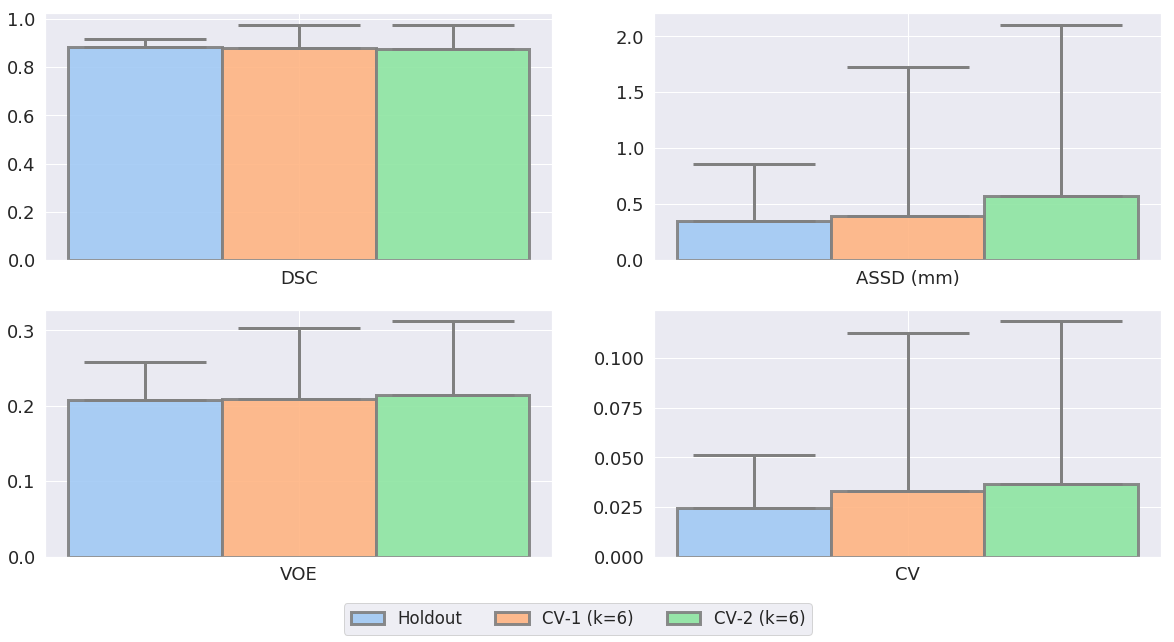

In [6]:
bar_graph_kwargs = {'spacing': 0.5, 'sig_marker_size': 20, 'line_width': 3, 'sig_thresholds': [0.05, 0.01]}
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.flatten()

for ind, m in enumerate(metrics):
    ax = axs[ind]
    
    np_mean = np.nanmean(np.asarray(metrics[m]), axis=1)
    np_std = np.nanstd(np.asarray(metrics[m]), axis=1)
    
    pysb.bar(np_mean, np_std, pmats[ind], ax=ax, x_label=[metrics_names[ind]], labels=ordered_keys, **bar_graph_kwargs)

plt.legend(loc='lower center', bbox_to_anchor=(-.15, -0.35), ncol=len(ordered_keys))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5, 0, 0))

# plt.text(-0.1, 0.5, '(A)', fontsize=30,
#             horizontalalignment='center',
#             verticalalignment='center', transform=axs[0].transAxes)
plt.savefig(os.path.join(base_path, 'cross-val-bar.png'), bbox_inches='tight', dpi=600)